### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Concatenate
from spektral.layers import GCNConv

2024-05-30 15:56:06.704397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 15:56:06.704536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 15:56:06.835403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading datasets

In [2]:
import os
import pandas as pd
# Base directory where your dataset is stored
base_directory = '/kaggle/input/apt-unraveled/Week5_Day6_06272021/Week5_Day6_06272021'

# Exclude Week 1 and list CSV files from Weeks 2 to 6
csv_files = []
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

# Load all CSV files from relevant weeks
dataframes = [pd.read_csv(file) for file in csv_files]
combined_data = pd.concat(dataframes, ignore_index=True)


# Check label distribution for balance
signature_counts = combined_data['Signature'].value_counts()
print("Signature distribution:")
print(signature_counts)

activity_counts = combined_data['Activity'].value_counts()
print("Activity distribution:")
print(activity_counts)

stage_counts = combined_data['Stage'].value_counts()
print("Stage distribution:")
print(stage_counts)

Signature distribution:
Signature
APT    6148
AA     4466
Name: count, dtype: int64
Activity distribution:
Activity
Normal                                       52620
Active Scanning: Scanning IP Blocks           4462
Encrypted Channel: Symmetric Cryptography     2660
Maintain Access                               2157
Data Transfer Size Limits                     1331
Active Scanning: Vulnerability Scanning          4
Name: count, dtype: int64
Stage distribution:
Stage
Benign                52620
Reconnaissance         4466
Establish Foothold     2660
Lateral Movement       2157
Data Exfiltration      1331
Name: count, dtype: int64


In [3]:
combined_data.shape

(63234, 89)

In [4]:
combined_data.columns

Index(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'src_port',
       'dst_ip', 'dst_mac', 'dst_oui', 'dst_port', 'protocol', 'ip_version',
       'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst

In [5]:
combined_data.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_is_guessed,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,Activity,Stage,DefenderResponse,Signature
0,0,0,192.168.0.11,fa:16:3e:e6:67:36,fa:16:3e,60689,8.8.8.8,fa:16:3e:b5:c4:4c,fa:16:3e,53,...,0,tile-service.weather.microsoft.com,NaN,NaN,NaN,NaN,Normal,Benign,Benign,NaN
1,1,0,192.168.0.11,fa:16:3e:e6:67:36,fa:16:3e,62264,184.30.179.31,fa:16:3e:b5:c4:4c,fa:16:3e,80,...,0,tile-service.weather.microsoft.com,NaN,NaN,Microsoft-WNS/10.0,text/xml,Normal,Benign,Benign,NaN
2,2,0,192.168.0.11,fa:16:3e:e6:67:36,fa:16:3e,46190,10.8.10.84,fa:16:3e:b5:c4:4c,fa:16:3e,443,...,1,NaN,NaN,NaN,NaN,NaN,Maintain Access,Lateral Movement,Benign,APT
3,3,0,192.168.0.11,fa:16:3e:e6:67:36,fa:16:3e,123,162.159.200.1,fa:16:3e:b5:c4:4c,fa:16:3e,123,...,0,NaN,NaN,NaN,NaN,NaN,Normal,Benign,Benign,NaN
4,4,0,192.168.0.11,fa:16:3e:e6:67:36,fa:16:3e,123,50.205.244.20,fa:16:3e:b5:c4:4c,fa:16:3e,123,...,0,NaN,NaN,NaN,NaN,NaN,Normal,Benign,Benign,NaN


### Chosing Label "Signature".

In [6]:
combined_data['Signature'] = combined_data['Signature'].apply(lambda x: 'APT' if x == 'APT' else 'Non-APT')

# Check the distribution of the new label
print(combined_data['Signature'].value_counts())

Signature
Non-APT    57086
APT         6148
Name: count, dtype: int64


### Chosing FEatures from droping NaNs more then 30%

In [7]:
null_percent = combined_data.isnull().mean()

# Set the threshold for removing columns
threshold = 0.30  # 30%

# Identify columns to drop (those with more than 30% missing values)
columns_to_drop = null_percent[null_percent > threshold].index

# Drop the identified columns from the DataFrame
df_cleaned = combined_data.drop(columns=columns_to_drop)

# Check the cleaned DataFrame
print("Columns with more than 30% null values removed:")
df_cleaned.info()

Columns with more than 30% null values removed:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63234 entries, 0 to 63233
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            63234 non-null  int64  
 1   expiration_id                 63234 non-null  int64  
 2   src_ip                        63234 non-null  object 
 3   src_mac                       63234 non-null  object 
 4   src_oui                       63234 non-null  object 
 5   src_port                      63234 non-null  int64  
 6   dst_ip                        63234 non-null  object 
 7   dst_mac                       63234 non-null  object 
 8   dst_oui                       63234 non-null  object 
 9   dst_port                      63234 non-null  int64  
 10  protocol                      63234 non-null  int64  
 11  ip_version                    63234 non-null  int64  
 12  vlan_id     

### Corellation

In [8]:
import pandas as pd
import numpy as np

# Assuming df_cleaned is your DataFrame after removing null-valued columns
# Compute correlation matrix
df_cleaned_corr = df_cleaned.drop(columns=["id" ,"expiration_id","src_ip" , "src_mac" ,"src_oui", "dst_ip" , "dst_mac" , "dst_oui", "application_name" , "application_category_name" , "Activity" , "Stage" , "DefenderResponse" , "Signature"])
correlation_matrix = df_cleaned_corr.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than threshold (e.g., 0.95)
threshold = 0.95
correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop correlated features
df_uncorrelated = df_cleaned_corr.drop(columns=correlated_features)

# Check the shape of the DataFrame after dropping correlated features
print("Shape of DataFrame after dropping correlated features:", df_uncorrelated.shape)

Shape of DataFrame after dropping correlated features: (63234, 54)


In [9]:
df_uncorrelated.head(5)

,src_port,dst_port,protocol,ip_version,vlan_id,tunnel_id,bidirectional_first_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,...,src2dst_urg_packets,src2dst_psh_packets,src2dst_rst_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,application_is_guessed
0,60689,53,17,4,0,0,1624820683947,17,2,294,...,0,0,0,0,0,0,0,0,0,0
1,62264,80,6,4,0,0,1624820683972,60038,11,5464,...,0,1,0,0,0,0,5,2,0,0
2,46190,443,6,4,0,0,1624820685998,71,8,552,...,0,1,2,0,0,0,4,1,0,1
3,123,123,17,4,0,0,1624820862169,30,2,180,...,0,0,0,0,0,0,0,0,0,0
4,123,123,17,4,0,0,1624820755441,61713,4,360,...,0,0,0,0,0,0,0,0,0,0


### Label Encoding to targeted label.

In [10]:
from sklearn.preprocessing import LabelEncoder

# Sample target classes
target_classes = combined_data["Signature"].values

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the target classes
Y = encoder.fit_transform(target_classes)

# Display the encoded target classes
print("Encoded target classes:")
for class_name, encoded_class in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{class_name}: {encoded_class}")

# Check the transformed target classes
print("Transformed target classes:")
print(Y)

Encoded target classes:
APT: 0
Non-APT: 1
Transformed target classes:
[1 1 0 ... 1 1 1]


### IP features convertion.

In [11]:
import pandas as pd
import numpy as np
import ipaddress
# import category_encoders as ce

# Sample DataFrame for demonstration
# df_cleaned = pd.read_csv('your_dataset.csv')  # Assuming you load your data this way
non_numeric_columns = ["src_ip", "src_mac", "src_oui", "dst_ip", "dst_mac",
                       "dst_oui", "application_name", "application_category_name"]

# List of non-numeric columns

# Function to validate and convert IP to integer
def validate_and_convert_ip(ip):
    try:
        # Check if it's a valid IPv4 address
        ip = ipaddress.IPv4Address(ip)
        return int(ip) / (2**32 - 1)  # Normalize to the range [0, 1]
    except:
        # Handle both IPv6 and invalid addresses by returning NaN
        return np.nan

# Create a copy of the IP-related columns to avoid modifying the original DataFrame
df_ip = df_cleaned[["src_ip", "dst_ip"]].copy()

# Apply the function to IP columns
df_ip['src_ip'] = df_ip['src_ip'].apply(validate_and_convert_ip)
df_ip['dst_ip'] = df_ip['dst_ip'].apply(validate_and_convert_ip)

# Handle NaN values that may have resulted from invalid IPs
df_ip['src_ip'].fillna(-1, inplace=True)
df_ip['dst_ip'].fillna(-1, inplace=True)

# Combine df_ip back with the other non-numeric columns for encoding
df_non_numeric = df_cleaned[non_numeric_columns].copy()
df_combined = pd.concat([df_ip, df_non_numeric], axis=1)



# Check the resulting dataframe
df_ip

/tmp/ipykernel_90/1783987800.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ip['src_ip'].fillna(-1, inplace=True)
/tmp/ipykernel_90/1783987800.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

,src_ip,dst_ip
0,0.752563,0.031373
1,0.752563,0.719218
2,0.752563,0.039185
3,0.752563,0.635251
4,0.752563,0.198455
...,...,...
63229,0.039078,0.937500
63230,0.039078,0.937500
63231,0.039078,0.937500
63232,0.039078,0.937500


### Other non-numeric conversion

In [12]:
import category_encoders as ce
# Create a DataFrame for non-numeric columns excluding IPs
non_ip_columns = ["src_mac", "src_oui", "dst_mac",
                  "dst_oui", "application_name", "application_category_name"]

# Select the non-IP non-numeric columns
df_non_numeric = df_cleaned[non_ip_columns].copy()

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=non_ip_columns)

# Assuming Y is your target variable
# Y = df_cleaned['target_variable']

# Fit and transform the data
encoded_non_ip = target_encoder.fit_transform(df_non_numeric, Y)

### All features

In [13]:
# Combine the encoded IP and non-IP columns with other numeric features
X = pd.concat([df_ip, encoded_non_ip, df_uncorrelated], axis=1)

# Check the resulting dataframe
X.head()

,src_ip,dst_ip,src_mac,src_oui,dst_mac,dst_oui,application_name,application_category_name,src_port,dst_port,...,src2dst_urg_packets,src2dst_psh_packets,src2dst_rst_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,application_is_guessed
0,0.752563,0.031373,0.884482,0.902774,0.881909,0.872252,1.000000,1.000000,60689,53,...,0,0,0,0,0,0,0,0,0,0
1,0.752563,0.719218,0.884482,0.902774,0.881909,0.872252,1.000000,1.000000,62264,80,...,0,1,0,0,0,0,5,2,0,0
2,0.752563,0.039185,0.884482,0.902774,0.881909,0.872252,0.399199,0.665742,46190,443,...,0,1,2,0,0,0,4,1,0,1
3,0.752563,0.635251,0.884482,0.902774,0.881909,0.872252,1.000000,1.000000,123,123,...,0,0,0,0,0,0,0,0,0,0
4,0.752563,0.198455,0.884482,0.902774,0.881909,0.872252,1.000000,1.000000,123,123,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X.shape

(63234, 62)

In [15]:
X.columns

Index(['src_ip', 'dst_ip', 'src_mac', 'src_oui', 'dst_mac', 'dst_oui',
       'application_name', 'application_category_name', 'src_port', 'dst_port',
       'protocol', 'ip_version', 'vlan_id', 'tunnel_id',
       'bidirectional_first_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_duration_ms',
       'dst2src_packets', 'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'bidirectional_syn_packets',
       'bidi

### Assigning random_sample

In [16]:
random_state = 42

### Data Balancing --> Undersampling

In [17]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import ClusterCentroids

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

under_sampling = ClusterCentroids(random_state=random_state)

X_resampled, y_resampled = under_sampling.fit_resample(X_scaled, Y)

print(pd.Series(y_resampled).value_counts())

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    6148
1    6148
Name: count, dtype: int64


In [18]:
X_resampled.head()

,src_ip,dst_ip,src_mac,src_oui,dst_mac,dst_oui,application_name,application_category_name,src_port,dst_port,...,src2dst_urg_packets,src2dst_psh_packets,src2dst_rst_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,application_is_guessed
0,1.0,0.536354,0.784951,0.0,0.692016,0.0,0.0,0.0,0.704911,0.006769,...,0.0,0.000677,0.166667,0.0,0.0,0.0,0.000956,0.000417,0.0,1.0
1,1.0,0.536354,0.784951,0.0,0.692016,0.0,0.0,0.0,0.704972,0.006769,...,0.0,0.004060,0.166667,0.0,0.0,0.0,0.003823,0.001668,0.0,0.0
2,1.0,0.536354,0.784951,0.0,0.692016,0.0,0.0,0.0,0.978985,0.006769,...,0.0,0.004060,0.166667,0.0,0.0,0.0,0.003823,0.001668,0.0,0.0
3,1.0,0.536354,0.784951,0.0,0.692016,0.0,0.0,0.0,0.704942,0.006769,...,0.0,0.000677,0.166667,0.0,0.0,0.0,0.001434,0.000417,0.0,1.0
4,1.0,0.536354,0.784951,0.0,0.692016,0.0,0.0,0.0,0.978955,0.006769,...,0.0,0.000677,0.166667,0.0,0.0,0.0,0.001195,0.000417,0.0,1.0


In [19]:
X_resampled.shape

(12296, 62)

### Training Model.

In [21]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Function to create Bi-LSTM model
def create_bilstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Convert DataFrame to numpy array and ensure proper shape
X_resampled_np = X_resampled.to_numpy()
X_resampled_np = np.expand_dims(X_resampled_np, axis=2)

# Initialize KFold
kf = KFold(n_splits=5)

# Arrays to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Placeholder for the best model
best_model = None
best_f1_score = -1
best_history = None

# Cross-validation loop
for train_index, test_index in kf.split(X_resampled_np):
    X_train, X_test = X_resampled_np[train_index], X_resampled_np[test_index]
    Y_train, Y_test = y_resampled[train_index], y_resampled[test_index]

    lstm_input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create Bi-LSTM model
    model = create_bilstm_model(lstm_input_shape)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Define the checkpoint callback to save the best model during training
    checkpoint_path = '/kaggle/working/best_model.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=False)

    # Training the model
    history = model.fit(
        X_train, Y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, Y_test),
        callbacks=[EarlyStopping(patience=3), checkpoint]  # Early stopping and model checkpoint
    )

    # Load the best model
    best_model_fold = load_model(checkpoint_path)

    # Evaluate the best model on the test data
    results = best_model_fold.evaluate(X_test, Y_test, verbose=0)
    accuracies.append(results[1])

    # Predictions
    Y_pred = best_model_fold.predict(X_test)
    Y_pred = (Y_pred > 0.5).astype(int)

    # Calculate precision, recall, and f1-score
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Keep track of the best model based on f1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = best_model_fold
        best_history = history



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 62, 64)            16896     
                                                                 
 dropout_2 (Dropout)         (None, 62, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
308/3

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 3s 8ms/step - loss: 0.2996 - accuracy: 0.8583 - val_loss: 0.8984 - val_accuracy: 0.0000e+00
Epoch 3/10
308/308 [==============================] - 3s 9ms/step - loss: 0.6629 - accuracy: 0.6251 - val_loss: 0.9819 - val_accuracy: 0.0000e+00
Epoch 4/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1872 - accuracy: 0.9174 - val_loss: 6.3465 - val_accuracy: 0.1228
Epoch 5/10
77/77 [==============================] - 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 62, 64)            16896     
                                                                 
 dropout_4 (Dropout)         (None, 62, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
308/3

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 3s 8ms/step - loss: 0.1629 - accuracy: 0.9329 - val_loss: 0.2989 - val_accuracy: 1.0000
Epoch 3/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1780 - accuracy: 0.9455 - val_loss: 0.3268 - val_accuracy: 0.9959
Epoch 4/10
308/308 [==============================] - 3s 9ms/step - loss: 0.1370 - accuracy: 0.9621 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 5/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0908 - accuracy: 0.9754 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/10
308/308 [==============================] - 3s 8ms/step - loss: 0.0510 - accuracy: 0.9875 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/10
308/308 [==============================] - 3s 8ms/step - loss: 0.0579 - accuracy: 0.9855 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 8/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0613 - accuracy: 0.9849 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 9/10
308/30

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 62, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 62, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
308/3

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 3s 9ms/step - loss: 0.1591 - accuracy: 0.9560 - val_loss: 0.1140 - val_accuracy: 0.9618
Epoch 3/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0709 - accuracy: 0.9824 - val_loss: 0.0563 - val_accuracy: 0.9870
Epoch 4/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0526 - accuracy: 0.9880 - val_loss: 0.0369 - val_accuracy: 0.9919
Epoch 5/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0545 - accuracy: 0.9871 - val_loss: 0.0614 - val_accuracy: 0.9866
Epoch 6/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1031 - accuracy: 0.9681 - val_loss: 0.0681 - val_accuracy: 0.9793
Epoch 7/10
77/77 [==============================] - 1s 3ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 62, 64)            16896     
                 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 3s 9ms/step - loss: 0.1267 - accuracy: 0.9614 - val_loss: 0.1618 - val_accuracy: 0.9386
Epoch 3/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1157 - accuracy: 0.9670 - val_loss: 0.1891 - val_accuracy: 0.9244
Epoch 4/10
308/308 [==============================] - 3s 9ms/step - loss: 0.0748 - accuracy: 0.9796 - val_loss: 0.0526 - val_accuracy: 0.9850
Epoch 5/10
308/308 [==============================] - 3s 8ms/step - loss: 0.0533 - accuracy: 0.9869 - val_loss: 0.0517 - val_accuracy: 0.9870
Epoch 6/10
308/308 [==============================] - 3s 8ms/step - loss: 0.0473 - accuracy: 0.9889 - val_loss: 0.0659 - val_accuracy: 0.9805
Epoch 7/10
308/308 [==============================] - 3s 8ms/step - loss: 0.0418 - accuracy: 0.9900 - val_loss: 0.0517 - val_accuracy: 0.9841
Epoch 8/10
77/77 [==============================] - 1s 3ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 3s 9ms/step - loss: 0.1799 - accuracy: 0.9427 - val_loss: 0.3912 - val_accuracy: 0.8154
Epoch 3/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1476 - accuracy: 0.9537 - val_loss: 0.1917 - val_accuracy: 0.9219
Epoch 4/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1129 - accuracy: 0.9684 - val_loss: 0.0572 - val_accuracy: 0.9756
Epoch 5/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1295 - accuracy: 0.9656 - val_loss: 0.1713 - val_accuracy: 0.9280
Epoch 6/10
308/308 [==============================] - 3s 8ms/step - loss: 0.1018 - accuracy: 0.9717 - val_loss: 0.1045 - val_accuracy: 0.9650
Epoch 7/10
77/77 [==============================] - 1s 3ms/step


### Calculate and print average results

In [22]:
# Calculate and print average results
print(f'Accuracy: {np.mean(accuracies):.4f}')
print(f'Precision: {np.mean(precisions):.4f}')
print(f'Recall: {np.mean(recalls):.4f}')
print(f'F1-Score: {np.mean(f1_scores):.4f}')

Accuracy: 0.8154
Precision: 0.5995
Recall: 0.5898
F1-Score: 0.5946


### Visualizing Training History

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


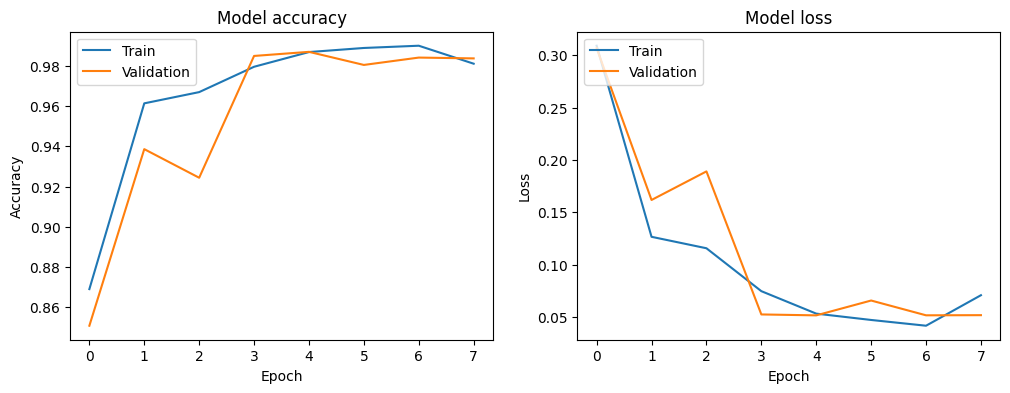

In [23]:
# Save the best model for future use
final_model_path = '/kaggle/working/final_best_model.h5'
best_model.save(final_model_path)

# Plot training & validation accuracy and loss for the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Done with training with Bi-LSTM

# Prediction begins

### Importing test dataset

In [24]:
# Base directory where your dataset is stored
dataframe = pd.read_csv('/kaggle/input/apt-unraveled/Week6_Day2_06292021/Week6_Day2_06292021/net1013x_Flow_labeled_w6_d5.csv')



# Check label distribution for balance
signature_counts = dataframe['Signature'].value_counts()
print("Signature distribution:")
print(signature_counts)

activity_counts = dataframe['Activity'].value_counts()
print("Activity distribution:")
print(activity_counts)

stage_counts = dataframe['Stage'].value_counts()
print("Stage distribution:")
print(stage_counts)


Signature distribution:
Signature
APT    1147
Name: count, dtype: int64
Activity distribution:
Activity
Normal                                       25045
Encrypted Channel: Symmetric Cryptography      525
Remove Traces                                  358
Data Transfer Size Limits                      183
Unsecured Credentials                           75
Remote System Discovery                          6
Name: count, dtype: int64
Stage distribution:
Stage
Benign                25045
Establish Foothold      525
Cover up                358
Data Exfiltration       258
Lateral Movement          6
Name: count, dtype: int64


### Data Shape

In [25]:
dataframe.shape

(26192, 89)

In [26]:
dataframe['Signature'] = dataframe['Signature'].apply(lambda x: 'APT' if x == 'APT' else 'Non-APT')

# Check the distribution of the new label
print(dataframe['Signature'].value_counts())

Signature
Non-APT    25045
APT         1147
Name: count, dtype: int64


### Signature test encoding

In [27]:
from sklearn.preprocessing import LabelEncoder

# Sample target classes
target_classes = dataframe["Signature"].values

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the target classes
Y_pred = encoder.fit_transform(target_classes)

# Display the encoded target classes
print("Encoded target classes:")
for class_name, encoded_class in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{class_name}: {encoded_class}")

# Check the transformed target classes
print("Transformed target classes:")
print(Y_pred)

Encoded target classes:
APT: 0
Non-APT: 1
Transformed target classes:
[0 1 1 ... 1 1 1]


### selecting uncorrelated data

In [28]:
uncorrelated_test = dataframe[['src_port', 'dst_port', 'protocol', 'ip_version', 'vlan_id',
       'tunnel_id', 'bidirectional_first_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_duration_ms',
       'dst2src_packets', 'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'bidirectional_syn_packets',
       'bidirectional_cwr_packets', 'bidirectional_ece_packets',
       'bidirectional_urg_packets', 'bidirectional_ack_packets',
       'bidirectional_psh_packets', 'bidirectional_rst_packets',
       'bidirectional_fin_packets', 'src2dst_cwr_packets',
       'src2dst_ece_packets', 'src2dst_urg_packets', 'src2dst_psh_packets',
       'src2dst_rst_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets',
       'dst2src_urg_packets', 'dst2src_ack_packets', 'dst2src_psh_packets',
       'dst2src_rst_packets', 'application_is_guessed']]

uncorrelated_test.columns

Index(['src_port', 'dst_port', 'protocol', 'ip_version', 'vlan_id',
       'tunnel_id', 'bidirectional_first_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_duration_ms',
       'dst2src_packets', 'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'bidirectional_syn_packets',
       'bidirectional_cwr_packets', 'bidirectional_ece_packets',
       'bidirectional_urg_packets', 'bidirectional_ack_packets',
       'b

In [29]:
type(uncorrelated_test)
uncorrelated_test.shape

(26192, 54)

### working on IP

In [30]:
# Function to validate and convert IP to integer
def validate_and_convert_ip(ip):
    try:
        # Check if it's a valid IPv4 address
        ip = ipaddress.IPv4Address(ip)
        return int(ip) / (2**32 - 1)  # Normalize to the range [0, 1]
    except:
        # Handle both IPv6 and invalid addresses by returning NaN
        return np.nan

# Create a copy of the IP-related columns to avoid modifying the original DataFrame
df_ip_pred = dataframe[["src_ip", "dst_ip"]].copy()

# Apply the function to IP columns
df_ip_pred['src_ip'] = df_ip_pred['src_ip'].apply(validate_and_convert_ip)
df_ip_pred['dst_ip'] = df_ip_pred['dst_ip'].apply(validate_and_convert_ip)

# Handle NaN values that may have resulted from invalid IPs
df_ip_pred['src_ip'].fillna(-1, inplace=True)
df_ip_pred ['dst_ip'].fillna(-1, inplace=True)

# Combine df_ip back with the other non-numeric columns for encoding
df_non_numeric = df_cleaned[non_numeric_columns].copy()
df_combined = pd.concat([df_ip, df_non_numeric], axis=1)



# Check the resulting dataframe
df_ip_pred 

/tmp/ipykernel_90/2628416595.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ip_pred['src_ip'].fillna(-1, inplace=True)
/tmp/ipykernel_90/2628416595.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,src_ip,dst_ip
0,0.039078,0.039185
1,0.039078,0.635251
2,0.039078,0.140147
3,0.039078,0.039078
4,0.039078,0.409211
...,...,...
26187,0.039078,0.937500
26188,0.039078,0.039078
26189,0.039078,0.817300
26190,0.039078,0.031373


### for non-IP

In [31]:
# Create a DataFrame for non-numeric columns excluding IPs
non_ip_columns = ["src_mac", "src_oui", "dst_mac",
                  "dst_oui", "application_name", "application_category_name"]

# Select the non-IP non-numeric columns
df_non_numeric = dataframe[non_ip_columns].copy()

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=non_ip_columns)

# Assuming Y is your target variable
# Y = df_cleaned['target_variable']

# Fit and transform the data
encoded_non_ip = target_encoder.fit_transform(df_non_numeric, Y_pred)

### Predicted data prepare

In [32]:
# Combine the encoded IP and non-IP columns with other numeric features
X_pred = pd.concat([df_ip_pred , encoded_non_ip, uncorrelated_test], axis=1)

# Check the resulting dataframe
X_pred.head()

,src_ip,dst_ip,src_mac,src_oui,dst_mac,dst_oui,application_name,application_category_name,src_port,dst_port,...,src2dst_urg_packets,src2dst_psh_packets,src2dst_rst_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,application_is_guessed
0,0.039078,0.039185,0.918583,0.956208,0.951707,0.952288,0.817454,0.941061,59004,443,...,0,1,2,0,0,0,5,1,0,1
1,0.039078,0.635251,1.000000,0.956208,0.951707,0.952288,1.000000,1.000000,123,123,...,0,0,0,0,0,0,0,0,0,0
2,0.039078,0.140147,1.000000,0.956208,0.951707,0.952288,1.000000,1.000000,41222,80,...,0,1,0,0,0,0,5,1,0,0
3,0.039078,0.039078,0.899297,0.956208,1.000000,1.000000,1.000000,1.000000,138,138,...,0,0,0,0,0,0,0,0,0,0
4,0.039078,0.409211,1.000000,0.956208,0.951707,0.952288,1.000000,1.000000,123,123,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_pred.shape

(26192, 62)

### Scaling data.

In [34]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import ClusterCentroids

scaler = MinMaxScaler()
X_pred = pd.DataFrame(scaler.fit_transform(X_pred), columns=X_pred.columns)

under_sampling = ClusterCentroids(random_state=random_state)

X_resampled_pred, Y_resampled_pred = under_sampling.fit_resample(X_pred, Y_pred)

print(pd.Series(Y_resampled_pred).value_counts())
X_pred.shape

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    1147
1    1147
Name: count, dtype: int64


(26192, 62)

### Reshaping for LSTM

In [35]:
import numpy as np

# Reshape the data to have one timestep
X_pred_lstm = np.expand_dims(X_resampled_pred, axis=1)

# Display the new shapes
print(f"Training set reshaped for LSTM: {X_resampled_pred.shape}")

Training set reshaped for LSTM: (2294, 62)


### Predictions

In [36]:
# Make predictions
Y_pred_lstm = best_model.predict(X_pred_lstm)

# Convert probabilities to binary labels
Y_pred_binary = (Y_pred_lstm > 0.5).astype(int)

# Display the predictions
print(Y_pred_binary)


72/72 [==============================] - 2s 3ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


### Evaluation

Accuracy: 0.4799
Precision: 0.4889
Recall: 0.8849
F1-Score: 0.6298
Confusion Matrix:
[[  86 1061]
 [ 132 1015]]


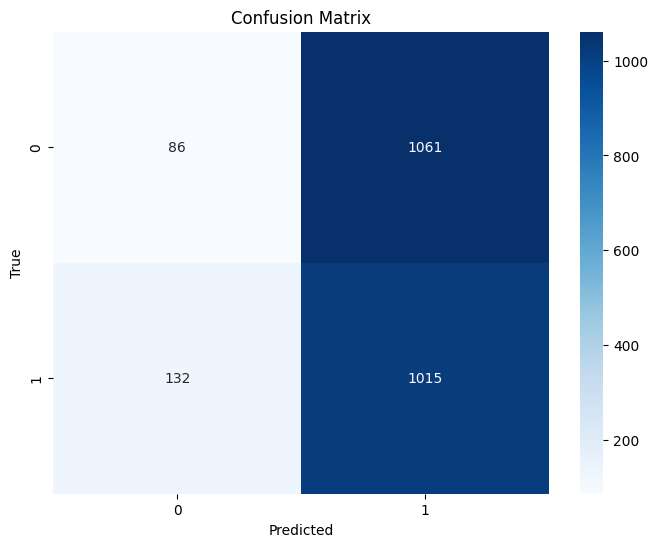

In [37]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'y_test' contains the true labels for the test data
# Ensure y_test is available; it should be the labels of your test dataset

# 1. Make Predictions
# Y_pred_lstm = model.predict(X_pred_lstm)
# Y_predicted_classes = (Y_pred_lstm > 0.5).astype(int).flatten()

# 2. Calculate Evaluation Metrics
accuracy = accuracy_score(Y_resampled_pred, Y_pred_binary )
precision = precision_score(Y_resampled_pred, Y_pred_binary )
recall = recall_score(Y_resampled_pred, Y_pred_binary )
f1 = f1_score(Y_resampled_pred, Y_pred_binary )
conf_matrix = confusion_matrix(Y_resampled_pred, Y_pred_binary )

# 3. Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Plot the confusion matrix for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
